In [705]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable
from tqdm import tqdm
plt.style.use('publication')


In [706]:
L = 10
n_c = 1
Nx = 100000
x = np.linspace(0,2 * L, Nx)
lxc = 1
dx = x[1] - x[0]


In [707]:
def generate_gaussian_perturbation(lcx : float) -> np.ndarray:
    """|
    generate_gaussian_perturbation generate a gaussian perturbation of density field expected to be linear

    Parameters
    ----------
    lcx : float
        radial correlation length if the turbulence

    Returns
    -------
    np.ndarray
        gaussian perturbated field of density
    """    
    phase = np.random.uniform(0, 2 * np.pi, Nx)
    rw = 2*np.pi*np.linspace(-0.5/dx,0.5/dx-1/dx/Nx,Nx)
    
    gaussian_spectrum =  np.exp(-rw**2 * lcx**2 / 8 + 1j * phase) / dx * lcx
    return np.fft.ifft(np.fft.ifftshift(gaussian_spectrum)).real


In [708]:
def generate_gaussian_samples(lcx : float, n_samples : int) -> np.ndarray:
    """
    generate_gaussian_samples generate a set of gaussian perturbations of density field expected to be linear

    Parameters
    ----------
    lcx : float
        radial correlation length if the turbulence
    n_samples : int
        number of samples to generate

    Returns
    -------
    np.ndarray
        gaussian perturbated field of density
    """    
    return np.array([generate_gaussian_perturbation(lcx) for _ in range(n_samples)])

In [709]:
gaussian_distribution = generate_gaussian_samples(lxc, 1000)

In [710]:
def integrate_decay(dn) : 
    
    x_c = x[dn + x/L > n_c][0]
    
    return (2 / 3e10)* np.trapz(1 / np.sqrt(1 - x[x < x_c]/L -  dn[x < x_c] / n_c), 
                                             dx=dx)

In [711]:
def sampling_decay(dn_distribution : np.ndarray) :
    
    td = map(integrate_decay, dn_distribution)
    return  list(td)


fig, ax = plt.subplots()
ax.plot(td)

In [712]:
def ampli_delay(dn_distribution : np.ndarray, ampli : Iterable) :
    rms_td = []
    rms_n = []
    for amp in tqdm(ampli):
        dn = dn_distribution
        dn  = amp * (dn - dn.mean()) /  dn.std()
        td = np.array(sampling_decay(dn))
        np.nan_to_num(td, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        mask = td > 0
        rms_td.append(np.std(td[mask]))
        rms_n.append(np.std(dn[mask]/ n_c))
    return np.array(rms_td), np.array(rms_n)

In [713]:
ampli = np.logspace(-4,0.5, 100)
rms_td, rms_n = ampli_delay(gaussian_distribution, ampli)

100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


In [714]:
dt_theo = 4 * L / 3e10 *  (1/2 * ampli / n_c * np.sqrt(L / lxc) -  0 * 1 /8 * (L / lxc)**(3/2) * ampli**2 / n_c**2)

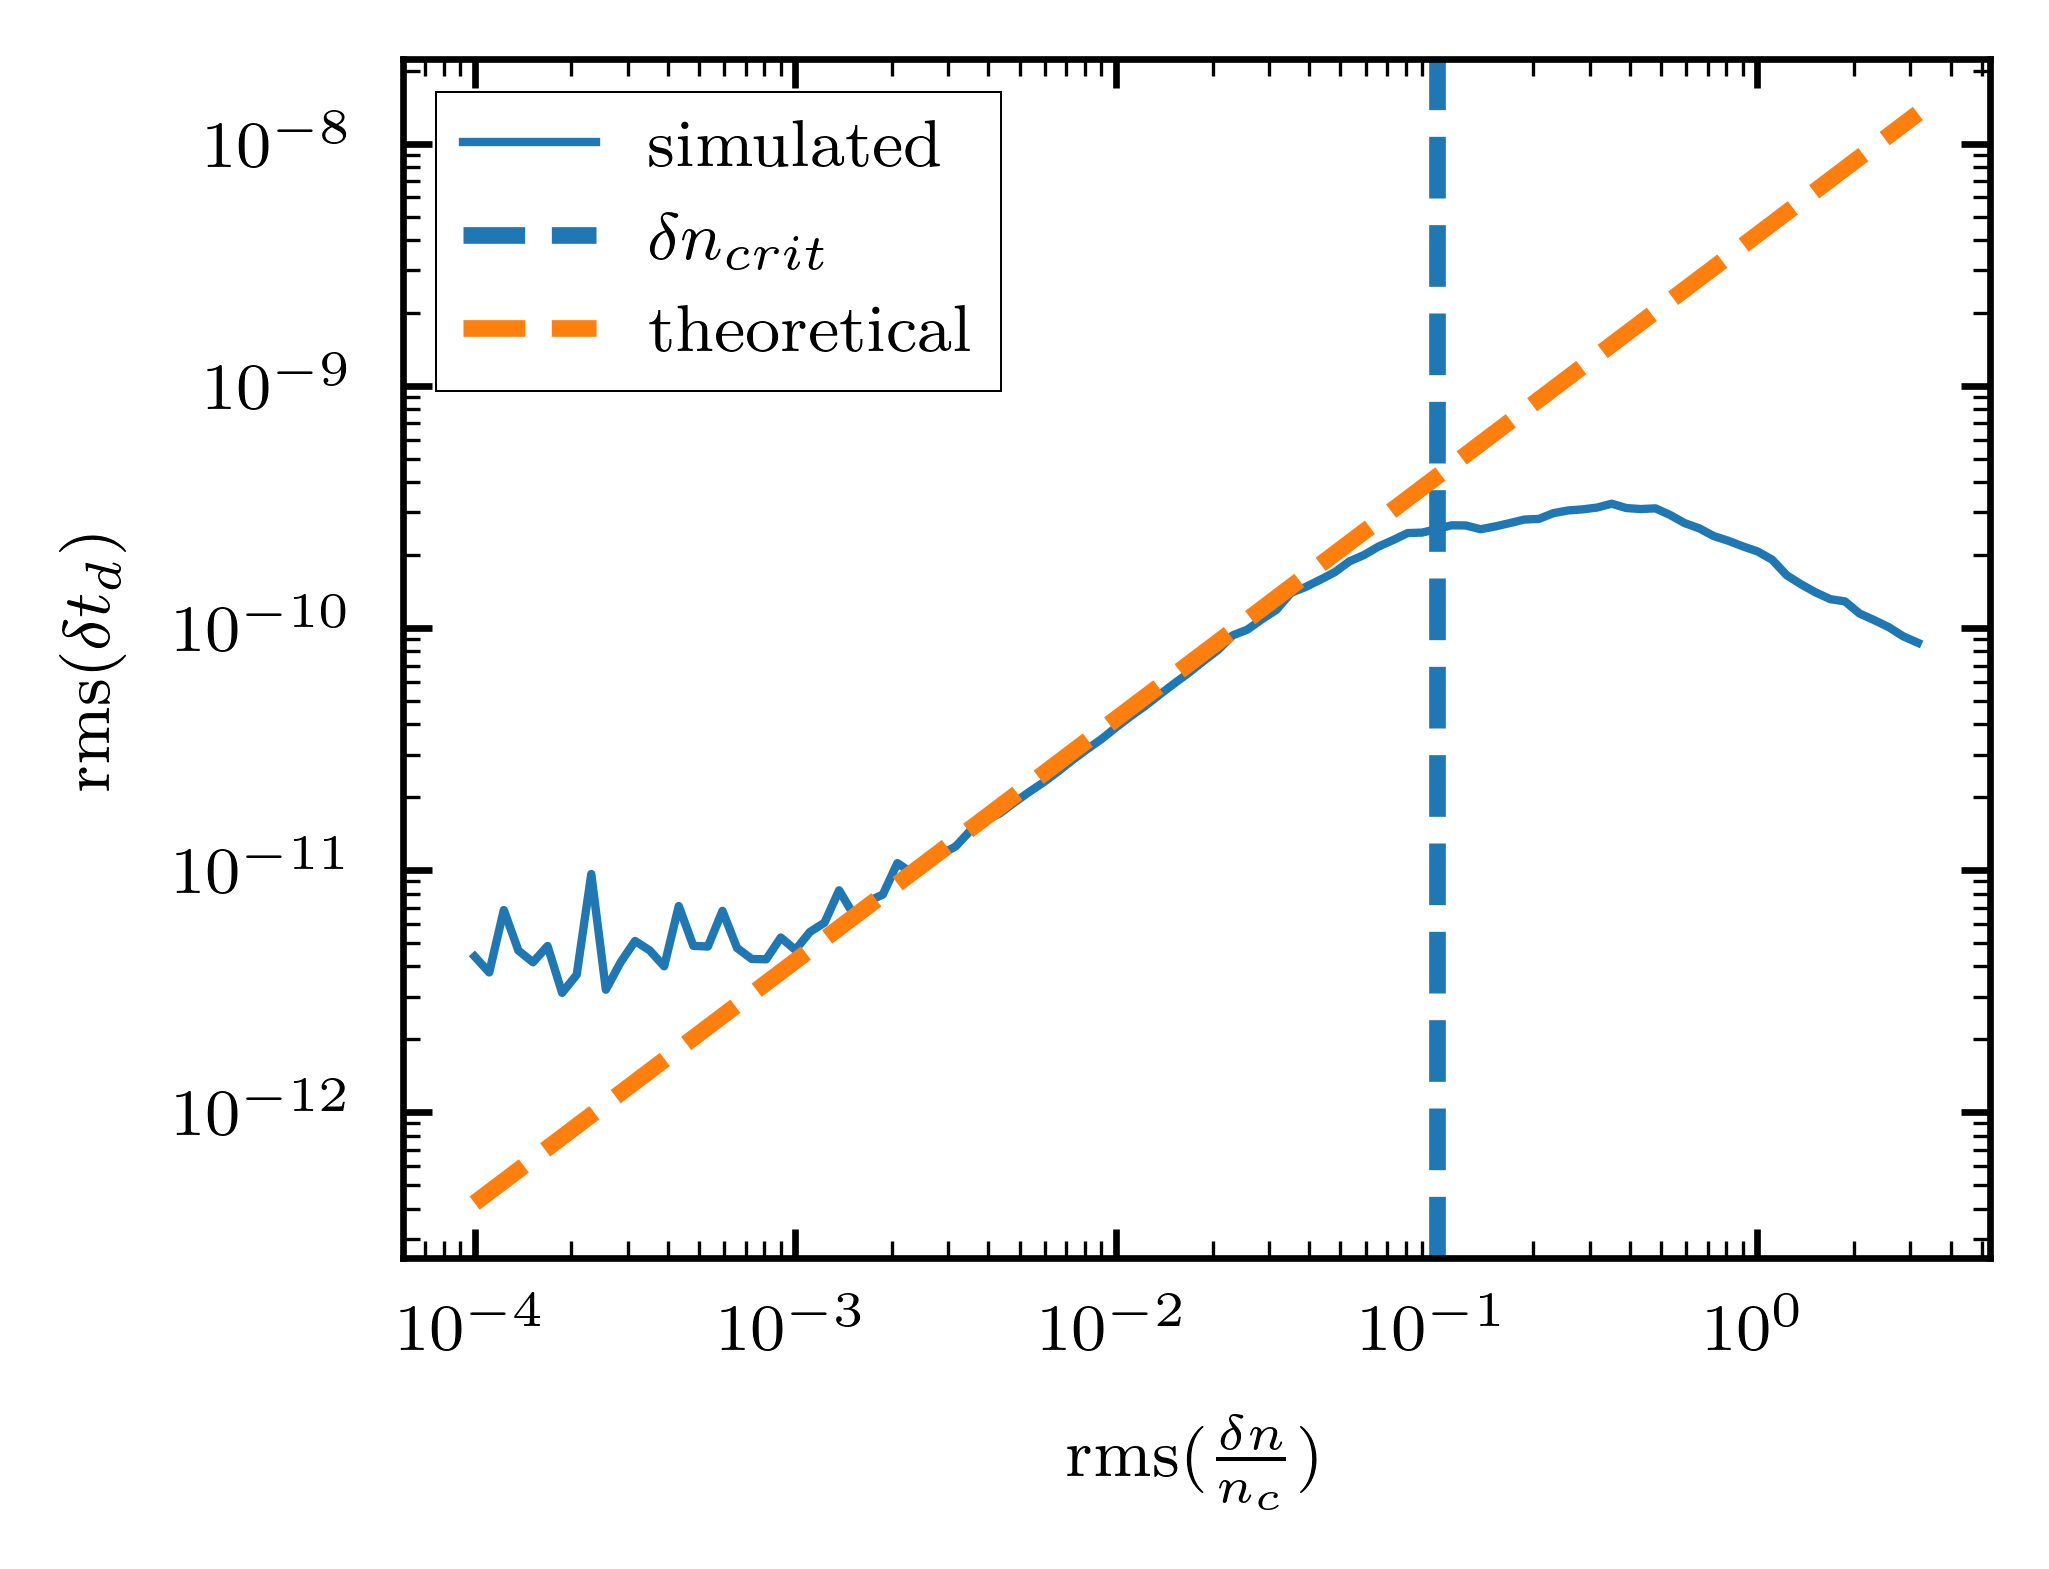

In [715]:
fig, ax = plt.subplots(1,1)




ax.loglog(ampli, rms_td, lw = 1, label='simulated')
# ax.loglog(x1, yfit, label=f'fit : {coeffs[0]:.2f}', ls = ':')
ax.axvline(n_c * lxc / L, label='$\\delta n_{crit}$', ls = '--')
ax.loglog(ampli,2 *  dt_theo  , label='theoretical', ls = '--')
# ax.loglog(ampli,dt_theo_2  , label='theoretical', ls = '--')

ax.set_xlabel('rms($\\frac{\delta n}{n_c}$)')
ax.set_ylabel('rms($\delta t_d$)')
ax.legend()


In [717]:
np.save('1d.npy', np.array([ampli, rms_td]))

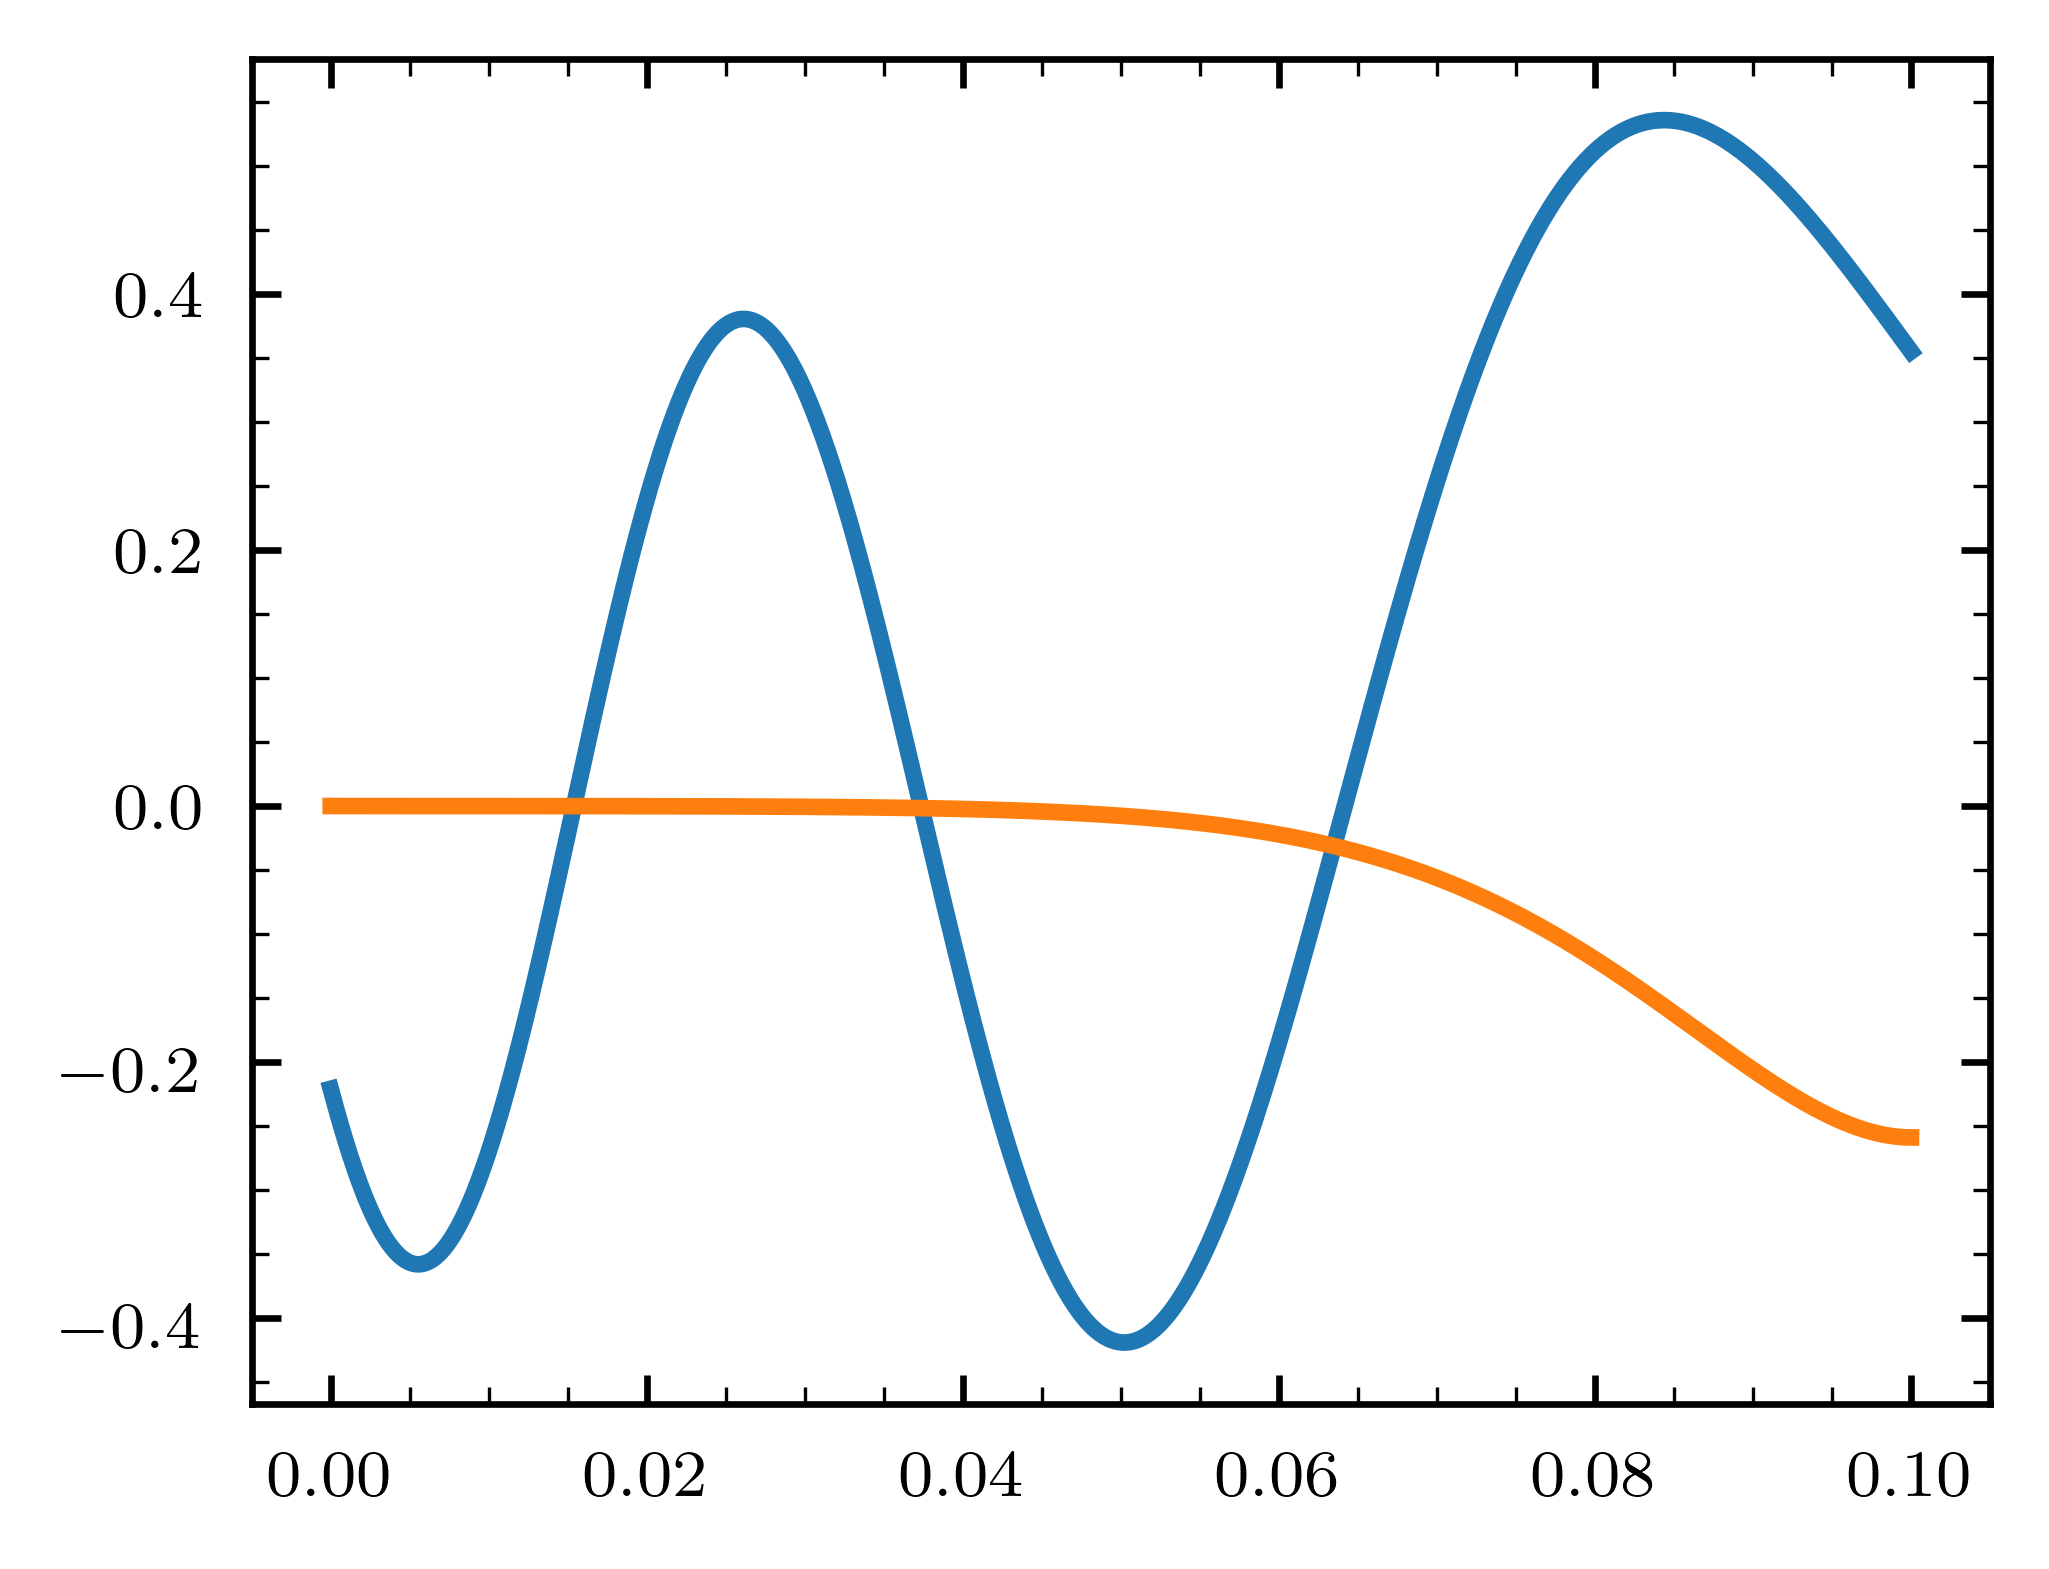

In [442]:
fig, ax = plt.subplots()
x = np.linspace(0, 0.1, 1000)
alpha = (50e9 ** 2 / (3e8 ** 2 * 0.1)) ** (1/3)
Ez1, Ez2 = airy(alpha * ( x - 0.1))[0], airy(alpha * (0.1 - x))[1]
ax.plot(x,Ez1)
ax.plot(x,Ez2)